In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import time
from torch_geometric.data import Data
import numpy.linalg as LA
import networkx as nx
from torch_geometric.utils import to_networkx
from torchsummary import summary


In [ ]:
if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

In [2]:
def build_graph(N, L=2):
    start = time.time()
    coord=[[i,j] for i in range(N) for j in range(N)]

    edge_1=[]
    edge_2=[]
    edge_weight=[]
    for i in range(N*N):
        for j in range(N*N):
            if not i==j:
                z=LA.norm(np.array(coord[i])-np.array(coord[j]))
                if float(z)<L:
                    edge_1.append(i)
                    edge_2.append(j)
                    edge_weight.append(np.exp(-z**2))    
    edge_index=[edge_1,edge_2]
    end = time.time()
    print("building time: "+ str(end - start))
    return edge_index, edge_weight
#from torch_geometric.utils import grid
#grid(28,28)

In [3]:
class BatchedIterator:
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
    
    def iterate_once(self):
        for start in range(0, len(self.X), self.batch_size):
            end = start + self.batch_size
            yield self.X[start:end], self.y[start:end]

In [4]:
def load_and_transform(train_batch, test_batch, dataset):
    start1 = time.time()
    if dataset=='mnist':
        mnist_train=datasets.MNIST('data', download=True, train=True)
        train_X=mnist_train.train_data/256
        train_y=mnist_train.targets
        mnist_test=datasets.MNIST('data', download=True, train=False)
        test_X=mnist_test.test_data/256
        test_y=mnist_test.targets
        N=28
        in_channel=1
        #edge_index, edge_weight= build_graph(N)
        train_X=train_X.view(60000,N*N).unsqueeze(2)
        test_X=test_X.view(10000,N*N).unsqueeze(2)
        
    if dataset=='cifar':
        cifar_train = datasets.CIFAR10('data',  train=True, download=True)
        train_X= torch.tensor(cifar_train.data/256).float()
        train_y=torch.tensor(cifar_train.targets)
        cifar_test = datasets.CIFAR10('data', train=False,download=True)
        test_X=torch.tensor(cifar_test.data/256).float()
        test_y=torch.tensor(cifar_test.targets)
        N=32
        in_channel=3
        train_X=train_X.view(50000,N*N,in_channel)
        test_X=test_X.view(10000,N*N,in_channel)
        #edge_index, edge_weight= build_graph(N)
            
    
    #edge_index = torch.tensor(edge_index, dtype=torch.long)
    #edge_weight=torch.tensor(edge_weight).float()
    
    train_loader =  BatchedIterator(train_X,train_y, batch_size=train_batch)
    test_loader =  BatchedIterator(test_X,test_y, batch_size=test_batch)
    end1 = time.time()
    print("loading time: "+ str(end1 - start1))
    return train_loader, test_loader




In [8]:
from torch_geometric.nn import ChebConv
class Cheb(nn.Module):
    def __init__(self, in_channel,K,hidden, size):
        super().__init__()
        self.conv1 = ChebConv(in_channel,hidden,K,node_dim=1)
        self.dense1 = nn.Linear(size*size*hidden,10)
        self.relu = nn.ReLU()
        self.hidden=hidden
        self.size = size
        self.layers = [self.conv1]
        
        self.history= None
        
    def forward(self,X,edge_index,edge_attr):
        h=X
        for layer in self.layers:
            h = layer(h, edge_index,edge_attr)
            h = self.relu(h)
        print(h.size())  
        h = h.view(-1,self.size*self.size*self.hidden)
        h = self.dense1(h)
        return h

In [9]:
def accuracy(pred, target):
        pred=pred.max(axis=1)[1]
        corrects = 100.0 *torch.eq(pred, target).sum().float() / len(target)
        return corrects.item()
    
def plot_history(history):
    fig = plt.figure(figsize=(15, 5))

    # Plot the loss history
    f1 = fig.add_subplot(121)
    plt.title('Loss')
    plt.plot(history['train_loss'][0], color='blue', label='train')
    plt.xlabel('Batches')
    plt.legend()

    # Plot the accuracy history
    f2 = fig.add_subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history['train_accuracy'][0], color='blue', label='train')
    plt.xlabel('Batches')
    plt.legend()
    
    plt.show()

In [10]:
def training_loop(BATCH, EPOCHS, MODEL, OPTIMIZER, DATASET, device, edge_index, edge_attr):
    summary(MODEL)
    if torch.cuda.is_available() is False:
        raise Exception("GPU device not found, runtime environment should be set to GPU")
    print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    
    train_loader, test_loader =load_and_transform(BATCH, 1000, DATASET) #load data
    
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [],'test_accuracy': [], 'epoch_loss':
              [], 'epoch_accuracy':[],'time':None}
    
   
    for epoch in range(EPOCHS):
        start=time.time()
        train_loss = []
        train_acc = []
        test_loss = 0
        test_acc = 0
        for step,(x,y) in enumerate(train_loader.iterate_once()):
            x=x.to(device)
            y=y.to(device)
            edge_index=edge_index.to(device)
            edge_attr=edge_attr.to(device)
            OPTIMIZER.zero_grad()  # Clear gradients.
            y_out = MODEL(x, edge_index, edge_attr) # Perform a single forward pass.
            loss = criterion(y_out, y)  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            OPTIMIZER.step()  # Update parameters based on gradients.
            train_loss.append(loss.detach().item())
            train_acc.append(accuracy(y_out, y))
            
        epoch_loss=float("{:.2f}".format(sum(train_loss)/(step+1)))
        epoch_acc=float("{:.2f}".format(sum(train_acc)/(step+1)))
        
        for step,(x,y) in enumerate(test_loader.iterate_once()):
            x=x.to(device)
            y=y.to(device)
            edge_index=edge_index.to(device)
            edge_attr=edge_attr.to(device)
            y_out =MODEL(x, edge_index, edge_attr)
            loss = criterion(y_out,  y) 
            test_loss += loss.detach().item()
            test_acc += accuracy(y_out, y)
        test_loss = test_loss / (step+1)
        test_acc = test_acc / (step+1)
        end=time.time()
        print(f"Epoch: {epoch} | Train loss: {epoch_loss} | Train accuracy: {epoch_acc}  | Test loss: {test_loss} | Test accuracy: {test_acc}| Time: {end-start}")
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_accuracy'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['epoch_loss'].append(epoch_loss)
        history['epoch_accuracy'].append(epoch_acc)
        history['time']=end-start
    return history

In [11]:
#building graphs
edge_mnist, edge_w_mnist= build_graph(28)
edge_cifar, edge_w_cifar= build_graph(32)


building time: 6.193103790283203
building time: 10.632996320724487


In [12]:
edge_mnist = torch.tensor(edge_mnist, dtype=torch.long)
edge_w_mnist=torch.tensor(edge_w_mnist).float()
edge_cifar = torch.tensor(edge_cifar, dtype=torch.long)
edge_w_cifar=torch.tensor(edge_w_cifar).float()


In [13]:
#MNIST
device = torch.cuda.current_device()
MODEL_Cheb=Cheb(in_channel=1,K=25, hidden=10, size=28).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Cheb.parameters(), lr=0.03)   
BATCH = 100
EPOCHS = 10

history = training_loop(BATCH, EPOCHS, MODEL_Cheb, OPTIMIZER, 'mnist', device, edge_mnist, edge_w_mnist)

Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          260
├─Linear: 1-2                            78,410
├─ReLU: 1-3                              --
Total params: 78,670
Trainable params: 78,670
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
loading time: 0.08986735343933105


/home/harsanyi/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/harsanyi/miniconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:63: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
t

torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
torch.Size([100, 784, 10])
t

KeyboardInterrupt: 

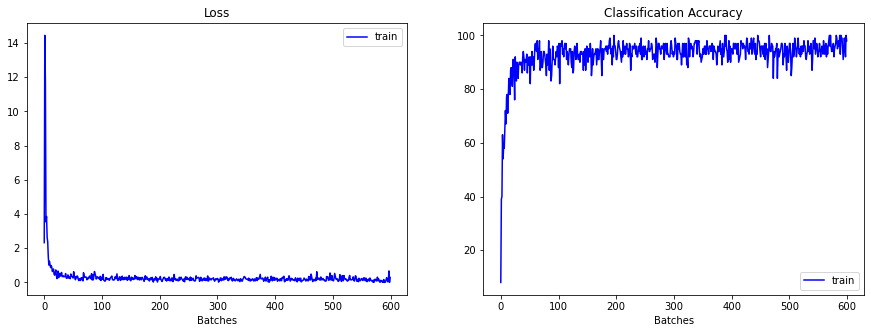

In [22]:
plot_history(history)

In [51]:
#CIFAR
device = torch.cuda.current_device()
MODEL_Cifar=Cheb(in_channel=3,K=25, hidden=10, size=32).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Cifar.parameters(), lr=0.003)   
BATCH = 100
EPOCHS = 10

history = training_loop(BATCH, EPOCHS, MODEL_Cifar, OPTIMIZER, 'cifar', device, edge_cifar, edge_w_cifar)

Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          260
├─Linear: 1-2                            78,410
├─ReLU: 1-3                              --
Total params: 78,670
Trainable params: 78,670
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Files already downloaded and verified
Files already downloaded and verified
loading time: 3.055574655532837
Epoch: 0 | Train loss: 2.67 | Train accuracy: 36.1  | Test loss: 1.6268916726112366 | Test accuracy: 44.80000228881836| Time: 10.65670657157898
Epoch: 1 | Train loss: 1.5 | Train accuracy: 48.44  | Test loss: 1.5490343928337098 | Test accuracy: 47.950001907348636| Time: 10.43131136894226
Epoch: 2 | Train loss: 1.37 | Train accuracy: 52.89  | Test loss: 1.5490949034690857 | Test accuracy: 48.35000228881836| Time: 10.272596836090088
Epoch: 3 | Train loss: 1.28 | Train accuracy: 56.09  | Test loss: 1.568381404876709 | Test accuracy: 47.9900016784668| Time: 10.328601360321045
Epoch: 4 | Train lo

In [11]:
from torch_geometric.nn import BatchNorm
from torch_geometric.utils import dropout_adj
class Batch_net(nn.Module):
    def __init__(self, in_channel,K,hidden, size):
        super().__init__()
        self.conv1 = ChebConv(in_channel,hidden,K,node_dim=1)
        self.bn1 = BatchNorm(1024)
        #self.conv2 = ChebConv(hidden,hidden,K,node_dim=1)
        #self.bn2 = BatchNorm(1024)
        self.dense1 = nn.Linear(size*size*hidden,10)
        self.relu = nn.ReLU()
        self.hidden=hidden
        self.size = size
        self.layers = [self.conv1]
        
        self.history= None
        
    def forward(self,X,edge_index,edge_attr):
        #edge_index,edge_attr=dropout_adj(edge_index,edge_attr)
        h=X
        h = self.conv1(h, edge_index,edge_attr)
        h = self.bn1(h)
        h = self.relu(h)
        #h = self.conv2(h, edge_index,edge_attr)
        #h = self.bn2(h)
        #h = self.relu(h)
        h = h.view(-1,self.size*self.size*self.hidden)
        h = self.dense1(h)
        return h

In [12]:
#CIFAR
device = torch.cuda.current_device()
MODEL_Batch=Batch_net(in_channel=3,K=30, hidden=30, size=32).to(device)#30,30
OPTIMIZER =  torch.optim.Adam(MODEL_Batch.parameters(), lr=0.003)   
BATCH = 100
EPOCHS = 10

history = training_loop(BATCH, EPOCHS, MODEL_Batch, OPTIMIZER, 'cifar', device, edge_cifar, edge_w_cifar)

Layer (type:depth-idx)                   Param #
├─ChebConv: 1-1                          2,730
├─BatchNorm: 1-2                         --
|    └─BatchNorm1d: 2-1                  2,048
├─Linear: 1-3                            307,210
├─ReLU: 1-4                              --
Total params: 311,988
Trainable params: 311,988
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Files already downloaded and verified
Files already downloaded and verified
loading time: 2.6213207244873047
Epoch: 0 | Train loss: 2.52 | Train accuracy: 36.2  | Test loss: 1.6821462154388427 | Test accuracy: 41.28000259399414| Time: 11.226565599441528
Epoch: 1 | Train loss: 1.56 | Train accuracy: 45.82  | Test loss: 1.610586929321289 | Test accuracy: 44.33000259399414| Time: 10.635267734527588


KeyboardInterrupt: 